In [1]:
import sys
import os

cur_dir = os.path.dirname(os.path.abspath(''))
sys.path.append(cur_dir)

from tools.utils import reload_module
from datasets.fabric import make_sigmod_ds, DatasetName
from tools.utils import set_seed
import numpy as np
import tensorflow_model_optimization as tfmot

set_seed(1234)

2023-09-01 12:42:02.780414: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-01 12:42:02.806665: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-01 12:42:03.196112: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Dataset
Create and load dataset. Split dataset into train-validation-test with 0.8, 0.1, 0.1 percentages

In [2]:
model_name = "cnn_1d_v013_small_radio_ml16b"
train_model = False
q_aware = False
expand2d = True

In [3]:
dataset_name = DatasetName.RADIOML_2016
radioml2016b_path = cur_dir + "/data/radioml_2016/RML2016.10b.dat"
radioml2016a_path = cur_dir + "/data/radioml_2016/RML2016.10a_dict.pkl"
dataset_path = os.path.abspath(radioml2016b_path)
radioml_ds = make_sigmod_ds(dataset_name)
# radioml_ds.load(dataset_path, expand2d=True)
radioml_ds.load(dataset_path, expand2d=expand2d)
splitted_radioml_ds = radioml_ds.split_train_val_test(0.8, 0.1)
print(f"Modulations: {radioml_ds.get_modulations()}")

{'8PSK': 0, 'AM-DSB': 1, 'BPSK': 2, 'CPFSK': 3, 'GFSK': 4, 'PAM4': 5, 'QAM16': 6, 'QAM64': 7, 'QPSK': 8, 'WBFM': 9}
Modulations: ['8PSK', 'AM-DSB', 'BPSK', 'CPFSK', 'GFSK', 'PAM4', 'QAM16', 'QAM64', 'QPSK', 'WBFM']


# Create Model
Create convolutional model

In [4]:
# reload_module("models.cnn.cnn_1d_v014")
# reload_module("models.layers.custom_batch_norm")
# reload_module("models.fabric")
from models.fabric import make_sigmod_model, Convolution01xConfiguration, ModelName
from evaluation.results_serialization import load_results


quantize_model = tfmot.quantization.keras.quantize_model

if train_model:
    cnn_1d_v012_3_configuration = Convolution01xConfiguration(
        input_shape=(1, 128, 2),
        # input_shape=(128, 2),
        n_classes=len(radioml_ds.get_modulations()),
        output_channels=[16, 32, 48, 64, 96],
        kernel_sizes=[8, 8, 8, 8, 8],
        paddings=["same", "same", "same", "same", "same",],
        max_pool_sizes=[2, 1, 2, 1, 2],
        max_pool_strides=[2, 1, 2, 1, 2],
        avg_size=16,
        dense_sizes=[96],
    )

    cnn_1d_v012_configuration = Convolution01xConfiguration(
        # input_shape=(1, 128, 2),
        input_shape=(128, 2),
        n_classes=len(radioml_ds.get_modulations()),
        output_channels=[32, 48, 64, 96],
        kernel_sizes=[8, 8, 8, 8],
        paddings=["same", "same", "same", "same",],
        max_pool_sizes=[2, 2, 1, 2],
        max_pool_strides=[2, 2, 1, 2],
        avg_size=16,
        dense_sizes=[96],
    )

    model_configuration = cnn_1d_v012_3_configuration

    # model = make_sigmod_model(ModelName.CNN_1D_V013, model_configuration)
    model = make_sigmod_model(ModelName.CNN_1D_V013, model_configuration)

    model.summary()

else:
    results = load_results(model_name + "_results/", load_model=True)
    model = results["model"]
    model.summary()
    


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1, 128, 2)]       0         
                                                                 
 CNN0_ (Conv2D)              (None, 1, 128, 16)        272       
                                                                 
 MAX_POOL_0_ (MaxPooling2D)  (None, 1, 64, 16)         0         
                                                                 
 CNN_REL0_ (ReLU)            (None, 1, 64, 16)         0         
                                                                 
 CNN1_ (Conv2D)              (None, 1, 64, 32)         4128      
                                                                 
 MAX_POOL_1_ (MaxPooling2D)  (None, 1, 64, 32)         0         
                                                                 
 CNN_REL1_ (ReLU)            (None, 1, 64, 32)         0     

2023-09-01 12:42:18.681622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-01 12:42:18.755857: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-09-01 12:42:18.756085: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

# Train model
Train model with Adam optimizer + lr decay + SparseCategoricalCrossentropy loss

In [5]:
import tensorflow as tf

def step_decay(epoch):
    # lrate = 0.001
    # factor = epoch // 8
    # lrate /= 10**factor
    # if (epoch > 16):
    #     return 0.0005
    return 0.001
    # return 0.0001
    lrate = 0.001
    if epoch >= 16:
        lrate /= 10
    if epoch >= 24:
        lrate /= 4
    if epoch >= 32:
        lrate /= 4
    if epoch >= 40:
        lrate /= 2
    # factor = epoch // 8
    # lrate /= 10**factor
    return lrate


if train_model:
    lrate = tf.keras.callbacks.LearningRateScheduler(step_decay)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )

    # N_EPOCHS = 16
    # N_EPOCHS = 48
    N_EPOCHS = 20
    # N_EPOCHS = 7
    BATCH_SIZE = 256

    h = model.fit(
        splitted_radioml_ds.train.data,
        splitted_radioml_ds.train.labels,
        epochs=N_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_data=(splitted_radioml_ds.val.data, splitted_radioml_ds.val.labels),
        callbacks=[lrate]
    )


## Fine tune model

In [6]:
if q_aware:
    print("Model is quantization aware")
    q_aware_model = quantize_model(model)
    q_aware_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=["accuracy"],
    )
else:
    print("Model is NOT quantization aware")

Model is NOT quantization aware


In [8]:
if q_aware:
    q_aware_model.fit(
        splitted_radioml_ds.train.data,
        splitted_radioml_ds.train.labels,
        epochs=6,
        batch_size=BATCH_SIZE,
        validation_data=(splitted_radioml_ds.val.data, splitted_radioml_ds.val.labels),
    )

# Evaluation
Check train plots, confusion matrices, snr to accuracy

In [9]:
if train_model:
    from evaluation.vizualization import plot_train, plot_snr_to_acc
    plot_train(h.history)

2023-08-29 23:50:06.865987: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-08-29 23:50:07.897016: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.6351}
8PSK test accuracy: 0.6349482401656315
AM-DSB test accuracy: 0.785226618409147
BPSK test accuracy: 0.6372875708097301
CPFSK test accuracy: 0.739468674997931
GFSK test accuracy: 0.7264893528875632
PAM4 test accuracy: 0.7225525500376853
QAM16 test accuracy: 0.5565736381977135
QAM64 test accuracy: 0.7198637534269337
QPSK test accuracy: 0.5479381883377444
WBFM test accuracy: 0.2755925155925156
Confusion matrix:
[[7667  719  396 1478  655  212  280  317  310   41]
 [ 620 9546  154  593  485   83   14    6   45  611]
 [ 961  757 7650 1184  621  576   77   50   85   43]
 [ 941  707  301 8935  740  170   71   65  106   47]
 [ 695  910  213 1062 8768  115   32   17   61  196]
 [ 692  493  637  867  396 8628   79   47   76   26]
 [ 901  420  316 1010  420  176 6621 1826  168   38]
 [ 628  251  236  680  281  166  943 8665  161   26]
 [1463  708  402 1348  634  197  267  223 6418   53]
 [ 616 6403  162  603  776   77   18    9  

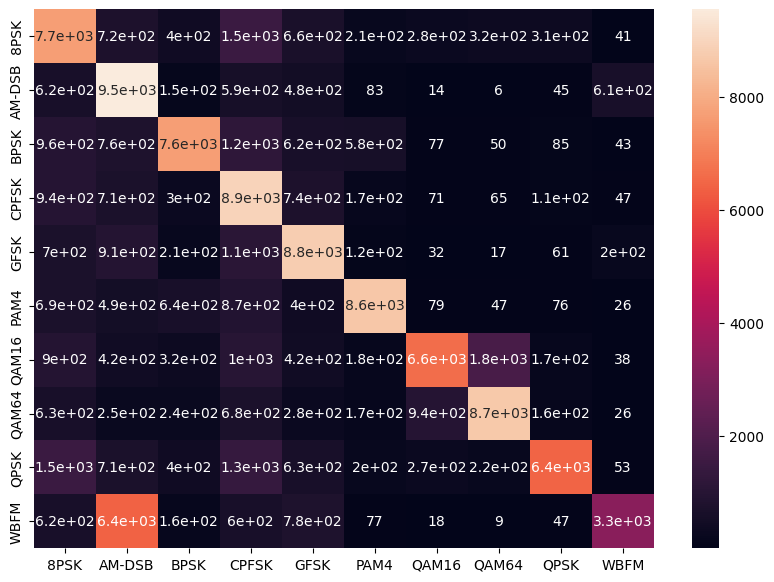

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.63415}
8PSK test accuracy: 0.6296603836253425
AM-DSB test accuracy: 0.7764295212765957
BPSK test accuracy: 0.6407662326892777
CPFSK test accuracy: 0.7438821375062428
GFSK test accuracy: 0.724845299652454
PAM4 test accuracy: 0.7242951907131011
QAM16 test accuracy: 0.5691749620381306
QAM64 test accuracy: 0.7206351804862078
QPSK test accuracy: 0.5386153461634592
WBFM test accuracy: 0.2690210552805973
Confusion matrix:
[[7583  766  427 1406  677  215  280  311  333   45]
 [ 606 9342  160  545  538   90   12    2   34  703]
 [ 996  675 7727 1212  555  623   74   42  101   54]
 [ 921  725  288 8937  724  156   69   70   85   39]
 [ 742  830  214 1058 8551  123   25   17   59  178]
 [ 659  534  605  903  381 8735   73   70   66   34]
 [ 863  427  272  919  411  209 6747 1810  166   30]
 [ 637  278  228  689  277  174  940 8804  161   29]
 [1475  758  430 1433  669  217  270  237 6465   49]
 [ 580 6443  162  628  760   77   19    7

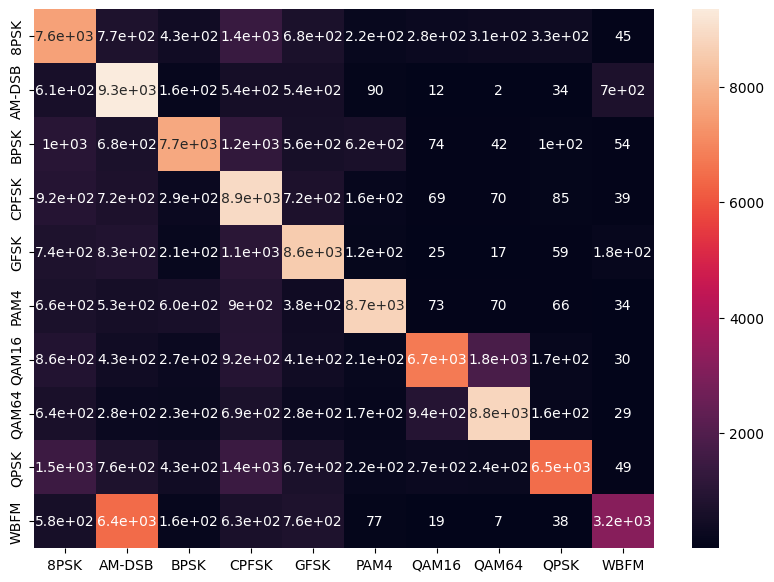

In [10]:
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation

cm_test, cls_to_acc_test = metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
)

cm_val, cls_to_acc_val = metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_modulations(),
)

SNR: -20 -- Overall test accuracy: 0.10793860372998845
SNR: -18 -- Overall test accuracy: 0.10837765957446809
SNR: -16 -- Overall test accuracy: 0.12950847173293073
SNR: -14 -- Overall test accuracy: 0.1728126047603084
SNR: -12 -- Overall test accuracy: 0.21794659147453974
SNR: -10 -- Overall test accuracy: 0.2952571810287241
SNR: -8 -- Overall test accuracy: 0.4236666666666667
SNR: -6 -- Overall test accuracy: 0.5641112618724559
SNR: -4 -- Overall test accuracy: 0.6997840172786177
SNR: -2 -- Overall test accuracy: 0.8066170388751034
SNR: 0 -- Overall test accuracy: 0.8766105054509415
SNR: 2 -- Overall test accuracy: 0.9111891620672353
SNR: 4 -- Overall test accuracy: 0.9203700644308608
SNR: 6 -- Overall test accuracy: 0.9251471825063078
SNR: 8 -- Overall test accuracy: 0.9246564000662362
SNR: 10 -- Overall test accuracy: 0.9187935034802784
SNR: 12 -- Overall test accuracy: 0.9273191489361702
SNR: 14 -- Overall test accuracy: 0.9250499666888741
SNR: 16 -- Overall test accuracy: 0.92359

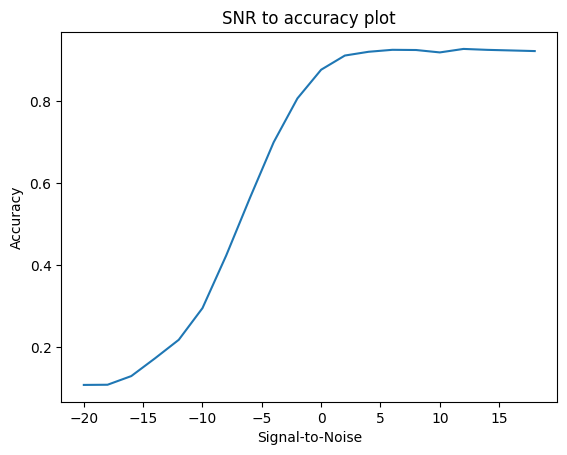

In [13]:
# reload_module("evaluation.metric_evaluation")
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_snr_to_acc

snr_to_acc_test = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
)
snr_to_acc_val = snr_to_metric_evaluation(
    model,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().val],
)
plot_snr_to_acc(snr_to_acc_test)

# Save results

In [8]:
# reload_module("evaluation.results_serialization")
from evaluation.results_serialization import dump_results

from copy import deepcopy

history = deepcopy(h.history)
history["lr"] = list(map(lambda x: float(x), history["lr"]))
# history = {}
model_name = "cnn_1d_v012_small_radio_ml16b_test"

if train_model:
    dump_results(
        model_name + "_results/",
        model=model,
        model_config=model_configuration,
        model_name=ModelName.CNN_1D_V013,
        dataset_name=DatasetName.RADIOML_2016,
        dataset_path=dataset_path,
        train_history=history,
        cm_test=cm_test,
        cls_to_acc_test=cls_to_acc_test,
        snr_to_acc_test=snr_to_acc_test,
        cm_val=cm_val,
        cls_to_acc_val=cls_to_acc_val,
        snr_to_acc_val=snr_to_acc_val,
        short_description="Smaller + dense + additional CNN at the beginning, 20 epochs lr==0.001",
        dump_model=True,
    )

# TF lite
Convert model to TF lite with/without quantization, and evaluate

1. No quantization

In [5]:
from deployment_tools import to_tf_lite, predict_tflite
from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation
from evaluation.vizualization import plot_snr_to_acc

model_path = f"{model_name}_results/model_original"
model.save(model_path)

# q_aware_model_path = f"{model_name}_results/model_q_aware"
# q_aware_model.save(q_aware_model_path)

model_tflile_no_quant = to_tf_lite(model_path, apply_quantization=False)

INFO:tensorflow:Assets written to: cnn_1d_v013_small_radio_ml16b_results/model_original/assets


INFO:tensorflow:Assets written to: cnn_1d_v013_small_radio_ml16b_results/model_original/assets
2023-09-01 12:42:43.965317: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-01 12:42:43.965337: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-09-01 12:42:43.965977: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_1d_v013_small_radio_ml16b_results/model_original
2023-09-01 12:42:43.967605: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-09-01 12:42:43.967619: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_1d_v013_small_radio_ml16b_results/model_original
2023-09-01 12:42:43.971786: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-09-01 12:42:43.972621: I tensorflow/cc/saved_model/loader.cc:231] Restoring Sav

In [15]:
# cm_test_tflite_no_quant, cls_to_acc_test_tflite_no_quant = metric_evaluation(
#     model_tflile_no_quant,
#     splitted_radioml_ds.test.data,
#     splitted_radioml_ds.test.labels,
#     radioml_ds.get_modulations(),
#     predict_func=predict_tflite,
# )

# reload_module("evaluation.metric_evaluation")
# from evaluation.metric_evaluation import metric_evaluation, snr_to_metric_evaluation


# snr_to_acc_test_tflite_no_quant = snr_to_metric_evaluation(
#     model_tflile_no_quant,
#     splitted_radioml_ds.test.data,
#     splitted_radioml_ds.test.labels,
#     radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
#     predict_func=predict_tflite,
# )
# plot_snr_to_acc(snr_to_acc_test_tflite_no_quant)

In [6]:
from deployment_tools import deploy_model_tflite

deploy_model_tflite(
    model_tflile_no_quant,
    test_data=splitted_radioml_ds.test.data,
    test_labels=splitted_radioml_ds.test.labels,
    model_name=model_name + "no_quant",
    classes=radioml_ds.get_modulations(),
    epsilon=0.01,
    apply_quantization=False,
    arena_size=200_000, 
    create_cfu_playground_proj=True
)

[debug] Export test data


0it [00:00, ?it/s]INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
10it [00:00, 290.60it/s]


Quantize model without quantization aware training

In [6]:
from deployment_tools import to_tf_lite, predict_tflite

representative_ds = splitted_radioml_ds.train.data[:4000].astype(np.float32)


2023-09-01 12:44:33.704028: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-09-01 12:44:33.704050: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-09-01 12:44:33.704178: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_1d_v013_small_radio_ml16b_results/model_original
2023-09-01 12:44:33.705261: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-09-01 12:44:33.705272: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_1d_v013_small_radio_ml16b_results/model_original
2023-09-01 12:44:33.708058: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-09-01 12:44:33.725034: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: cnn_1d_v013_small_radio_ml16b_results/model_original
2023-09-01 12:44:33.731821: I te

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.6179916666666667}
8PSK test accuracy: 0.6929192546583851
AM-DSB test accuracy: 0.8482355844369499
BPSK test accuracy: 0.6252915694768411
CPFSK test accuracy: 0.6757427791111479
GFSK test accuracy: 0.6577181208053692
PAM4 test accuracy: 0.709907042961226
QAM16 test accuracy: 0.5712004034969738
QAM64 test accuracy: 0.6315527124698845
QPSK test accuracy: 0.5411081704089473
WBFM test accuracy: 0.22112266112266113
Confusion matrix:
[[ 8367  1254   394   755   424   179   216   111   299    76]
 [ 1032 10312   118   215   218    36     2     0     4   220]
 [ 1830  1211  7506   463   366   521    12     4    21    70]
 [ 1748  1193   235  8165   483   129    26     2    25    77]
 [ 1463  1622   138   472  7938    83     8     1    10   334]
 [ 1314   835   596   359   274  8477    14     5    18    49]
 [ 1432   788   317   608   301   233  6795  1207   146    69]
 [  946   531   310   467   203   216  1551  7602   142    69]
 [

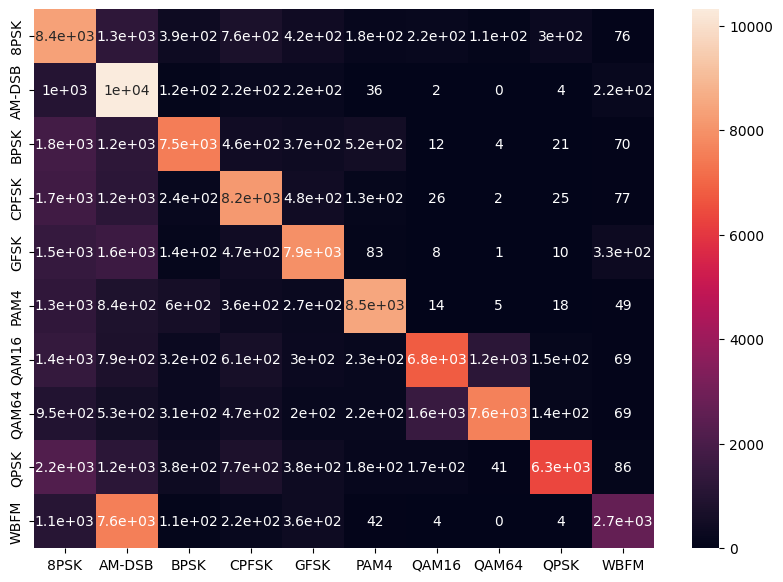

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.6169916666666667}
8PSK test accuracy: 0.6862077555426389
AM-DSB test accuracy: 0.8462433510638298
BPSK test accuracy: 0.6271664317107555
CPFSK test accuracy: 0.6806226069585484
GFSK test accuracy: 0.6557599389675342
PAM4 test accuracy: 0.711028192371476
QAM16 test accuracy: 0.5814071199595073
QAM64 test accuracy: 0.631497094212982
QPSK test accuracy: 0.527701407981338
WBFM test accuracy: 0.21818639375891286
Confusion matrix:
[[ 8264  1272   425   769   415   187   202   120   305    84]
 [ 1021 10182    98   188   244    48     4     1     3   243]
 [ 1885  1182  7563   459   341   519    16     2    24    68]
 [ 1703  1183   238  8177   471   128    18     1    22    73]
 [ 1470  1547   144   459  7736    83     2     2     9   345]
 [ 1276   881   588   344   283  8575    30    10    17    56]
 [ 1383   761   314   570   281   240  6892  1193   153    67]
 [  987   543   295   459   208   242  1564  7715   133    71]
 [ 2

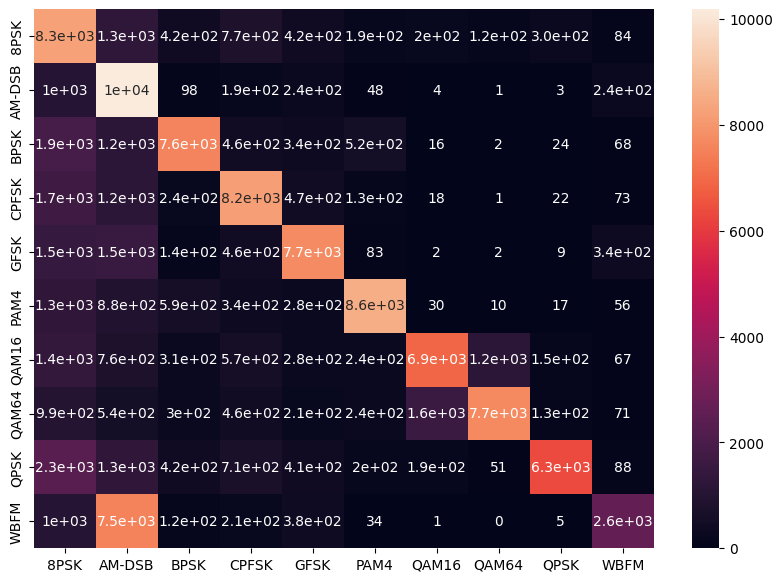

SNR: -20 -- Overall test accuracy: 0.10678329757385707
SNR: -18 -- Overall test accuracy: 0.11336436170212766
SNR: -16 -- Overall test accuracy: 0.12481127327629592
SNR: -14 -- Overall test accuracy: 0.13861884009386524
SNR: -12 -- Overall test accuracy: 0.16636258085918063
SNR: -10 -- Overall test accuracy: 0.26469605878423513
SNR: -8 -- Overall test accuracy: 0.38533333333333336
SNR: -6 -- Overall test accuracy: 0.5245929443690638
SNR: -4 -- Overall test accuracy: 0.6667220468516365
SNR: -2 -- Overall test accuracy: 0.7857733664185277
SNR: 0 -- Overall test accuracy: 0.8698381235546746
SNR: 2 -- Overall test accuracy: 0.9028265596253554
SNR: 4 -- Overall test accuracy: 0.9116140756649596
SNR: 6 -- Overall test accuracy: 0.9152228763666947
SNR: 8 -- Overall test accuracy: 0.9135618479880775
SNR: 10 -- Overall test accuracy: 0.9098442161087172
SNR: 12 -- Overall test accuracy: 0.918468085106383
SNR: 14 -- Overall test accuracy: 0.9168887408394404
SNR: 16 -- Overall test accuracy: 0.913

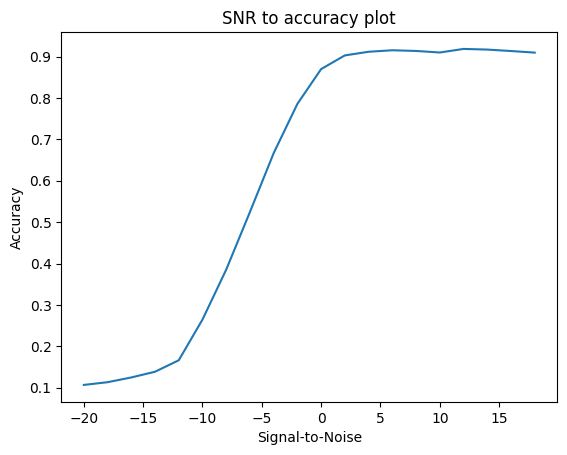

In [8]:
model_tflile = to_tf_lite(model_path, apply_quantization=True, representative_ds=representative_ds)

cm_test_tflite, cls_to_acc_test_tflite = metric_evaluation(
    model_tflile,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)

cm_val_tflite, cls_to_acc_val_tflite = metric_evaluation(
    model_tflile,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)


snr_to_acc_test_tflite = snr_to_metric_evaluation(
    model_tflile,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)

snr_to_acc_val_tflite = snr_to_metric_evaluation(
    model_tflile,
    splitted_radioml_ds.val.data,
    splitted_radioml_ds.val.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().val],
    predict_func=predict_tflite,
)

plot_snr_to_acc(snr_to_acc_test_tflite)

In [17]:
reload_module("evaluation.results_serialization")
from evaluation.results_serialization import dump_results

dump_results(
    model_name + "_quant_results/",
    model=model_tflile,
    model_config=results["model_configuration"],
    model_name=ModelName.CNN_1D_V013,
    dataset_name=DatasetName.RADIOML_2016,
    dataset_path=dataset_path,
    train_history=None,
    cm_test=cm_test_tflite,
    cls_to_acc_test=cls_to_acc_test_tflite,
    snr_to_acc_test=snr_to_acc_test_tflite,
    cm_val=cm_val_tflite,
    cls_to_acc_val=cls_to_acc_val_tflite,
    snr_to_acc_val=snr_to_acc_val_tflite,
    short_description="Smaller + dense + additional CNN at the beginning, 20 epochs lr==0.001. Applied quantization",
    dump_model=True,
    is_tflite=True
)

2023-08-29 00:26:17.072452: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2023-08-29 00:26:17.072485: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2023-08-29 00:26:17.072673: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: cnn_1d_v012_small_radio_ml16b_q_aware_test_batch_norm_results/model_q_aware
2023-08-29 00:26:17.079516: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-08-29 00:26:17.079544: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: cnn_1d_v012_small_radio_ml16b_q_aware_test_batch_norm_results/model_q_aware
2023-08-29 00:26:17.101702: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2023-08-29 00:26:17.274945: I tensorflow/cc/saved_model/loader.cc:215] Running initialization op on SavedModel bundle at path: cnn_1d_v012_small_radio_ml16b_q_aware_t

Preds shape: (120000, 10)
Overall test accuracy: {'Overall': 0.5387916666666667}
8PSK test accuracy: 0.67527950310559
AM-DSB test accuracy: 0.6688327712429053
BPSK test accuracy: 0.7085138287237588
CPFSK test accuracy: 0.6559629231151204
GFSK test accuracy: 0.713812246250725
PAM4 test accuracy: 0.6485218993384139
QAM16 test accuracy: 0.5955783456624075
QAM64 test accuracy: 0.13300656309711723
QPSK test accuracy: 0.36736958934517205
WBFM test accuracy: 0.21546777546777546
Confusion matrix:
[[8154  118 1507  517  852  204  397   10  285   31]
 [ 896 8131 1441  308  720  188   54    6   59  354]
 [1470  141 8505  476  789  336  145   10   95   37]
 [1371  127 1354 7926  868  199   98    5  106   29]
 [ 903  213 1344  499 8615  178   55    3   76  183]
 [ 855   92 1825  326  555 7744  405   55   63   21]
 [1903   80  975  368  521  152 7085  635  162   15]
 [1482   48  637  287  332  104 7407 1601  132    7]
 [3904  128 1414  508  765  188  469   16 4303   18]
 [ 905 5533 1314  355 1020  1

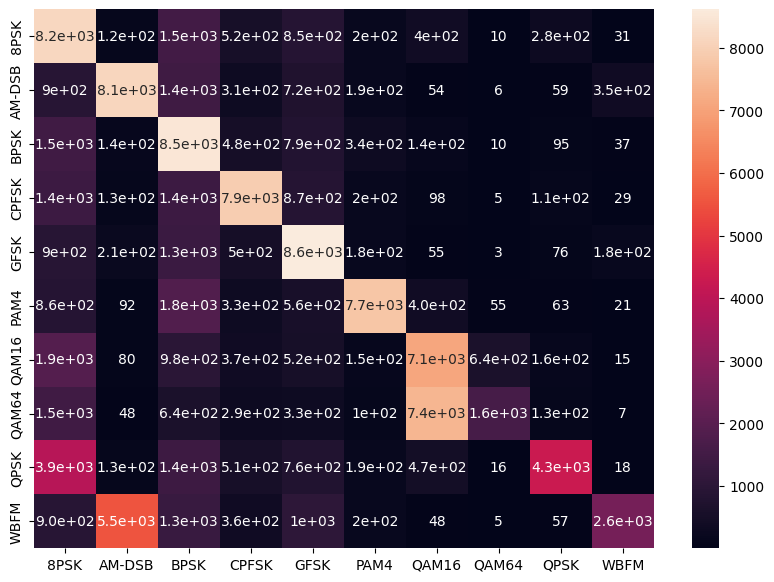

SNR: -20 -- Overall test accuracy: 0.10117181052979039
SNR: -18 -- Overall test accuracy: 0.10023271276595745
SNR: -16 -- Overall test accuracy: 0.10300285187049153
SNR: -14 -- Overall test accuracy: 0.10945357023131076
SNR: -12 -- Overall test accuracy: 0.12207662962348648
SNR: -10 -- Overall test accuracy: 0.1795257181028724
SNR: -8 -- Overall test accuracy: 0.3001666666666667
SNR: -6 -- Overall test accuracy: 0.4908412483039349
SNR: -4 -- Overall test accuracy: 0.6197042698122611
SNR: -2 -- Overall test accuracy: 0.6990901571546733
SNR: 0 -- Overall test accuracy: 0.755203171456888
SNR: 2 -- Overall test accuracy: 0.7860846295367119
SNR: 4 -- Overall test accuracy: 0.7895258549479597
SNR: 6 -- Overall test accuracy: 0.807569386038688
SNR: 8 -- Overall test accuracy: 0.8138764696141745
SNR: 10 -- Overall test accuracy: 0.7989724892277097
SNR: 12 -- Overall test accuracy: 0.7974468085106383
SNR: 14 -- Overall test accuracy: 0.8067954696868754
SNR: 16 -- Overall test accuracy: 0.799364

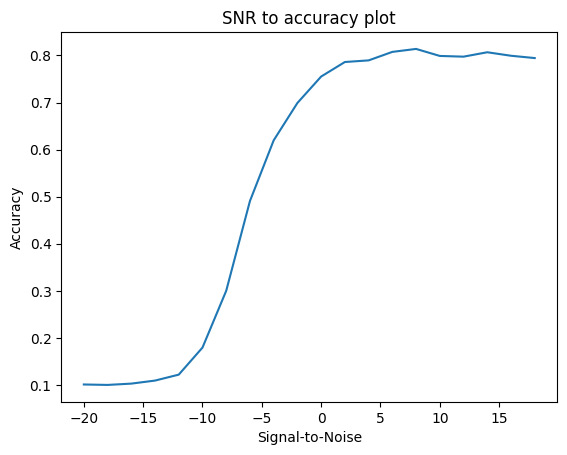

In [33]:
# reload_module("deployment_tools")

# model_tflile = to_tf_lite(model_path, apply_quantization=True, representative_ds=representative_ds)
q_aware_model_tflile = to_tf_lite(q_aware_model_path, apply_quantization=True, representative_ds=representative_ds)

cm_test_q_aware_tflite, cls_to_acc_test_q_aware_tflite = metric_evaluation(
    q_aware_model_tflile,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_modulations(),
    predict_func=predict_tflite,
)

snr_to_acc_test_q_aware_tflite = snr_to_metric_evaluation(
    q_aware_model_tflile,
    splitted_radioml_ds.test.data,
    splitted_radioml_ds.test.labels,
    radioml_ds.get_snrs()[radioml_ds.get_split_indecies().test],
    predict_func=predict_tflite,
)
plot_snr_to_acc(snr_to_acc_test_q_aware_tflite)

In [13]:
interpreter = tf.lite.Interpreter(model_content=model_tflile)
print(interpreter.get_input_details()[0])
print(interpreter.get_output_details()[0])

# interpreter = tf.lite.Interpreter(model_content=q_aware_model_tflile)
# print(interpreter.get_input_details()[0])
# print(interpreter.get_output_details()[0])

{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([  1, 128,   2], dtype=int32), 'shape_signature': array([ -1, 128,   2], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.0004541363741736859, -4), 'quantization_parameters': {'scales': array([0.00045414], dtype=float32), 'zero_points': array([-4], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'StatefulPartitionedCall:0', 'index': 54, 'shape': array([ 1, 10], dtype=int32), 'shape_signature': array([-1, 10], dtype=int32), 'dtype': <class 'numpy.int8'>, 'quantization': (0.00390625, -128), 'quantization_parameters': {'scales': array([0.00390625], dtype=float32), 'zero_points': array([-128], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}


In [18]:
from deployment_tools import deploy_model_tflite

deploy_model_tflite(
    model_tflile,
    test_data=splitted_radioml_ds.test.data,
    test_labels=splitted_radioml_ds.test.labels,
    model_name=model_name,
    classes=radioml_ds.get_modulations(),
    epsilon=20,
    apply_quantization=True,
    arena_size=200_000, 
    create_cfu_playground_proj=True
)

[debug] Export test data


10it [00:00, 1619.42it/s]